# 2022 Store Sales Forecasting Kaggle Competition

### Merging and Cleaning of the data

Start date: 28/12/2022
Author: James To

In [93]:
# import libraries

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [94]:
# Set data folder path
datafolder = 'C:/Users/James/Documents/Kaggle/Store Sales/data/' #UPDATE

# Read in data
stores_rawdf = pd.read_csv(datafolder + 'stores.csv')
transactions_rawdf = pd.read_csv(datafolder + 'transactions.csv')
train_rawdf = pd.read_csv(datafolder + 'train.csv')
test_rawdf = pd.read_csv(datafolder + 'test.csv')
oil_rawdf = pd.read_csv(datafolder + 'oil.csv')
holidays_events_rawdf = pd.read_csv(datafolder + 'holidays_events.csv')

In [95]:
# Manipulate train dataset ----

# Split date
train = train_rawdf.copy()
train['year'] = train['date'].str[:4].astype(int)
train['month'] = train['date'].str[5:7].astype(int)
train['day'] = train['date'].str[8:10].astype(int)

# Create a sales to promo ratio
train['sales_to_promo_ratio'] = train['sales'] / train['onpromotion']

In [96]:
# Make all dates to datetime


In [97]:
# merged onto training dataset
train_merged = train.merge(stores_rawdf, on = 'store_nbr', how = 'left')
train_merged = train_merged.merge(transactions_rawdf, on = ['date', 'store_nbr'], how = 'left')

In [98]:
# Check merged dataset
train_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,city,state,type,cluster,transactions
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,inf,Quito,Pichincha,B,6,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,154.55300,Quito,Pichincha,B,6,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,16.34952,Quito,Pichincha,B,6,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,15.12500,Quito,Pichincha,B,6,2155.0
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,2017,8,15,inf,Quito,Pichincha,B,6,2155.0


In [99]:
len(train_merged) == len(train_rawdf)

True

# Merging Holiday

Merging stores and holiday_events datatsets - rule to get the 'locale name':
locale = regional -> merged with 'state' column from stores dataset
local = local -> merged with 'city' column from stores dataset

In [100]:
# Manipulate holidays events


# Make copy
holidays_events = holidays_events_rawdf.copy()

# Make Navidad one holiday (Christmas)
holidays_events.loc[holidays_events['description'].str.contains('Navidad'), 'description'] = 'Christmas'
navidad_check = holidays_events[holidays_events['description'].str.contains('Navidad')]

# Make Terremoto one holiday
holidays_events.loc[holidays_events['description'].str.contains('Terremoto'), 'description'] = 'Earthquake'
terremoto_check = holidays_events[holidays_events['description'].str.contains('Terremoto')]

# Make futbol one holiday
holidays_events.loc[holidays_events['description'].str.contains('futbol'), 'description'] = '2014 FIFA World Cup'
futbol_check = holidays_events[holidays_events['description'].str.contains('2014 FIFA World Cup')]
print(len(navidad_check), len(terremoto_check), len(futbol_check))


0 0 14


In [101]:
# Duplicate dates
date_check = holidays_events.date.value_counts()
date_check


2014-06-25    4
2017-06-25    3
2016-06-25    3
2015-06-25    3
2013-06-25    3
             ..
2014-07-13    1
2014-07-12    1
2014-07-09    1
2014-07-08    1
2017-12-26    1
Name: date, Length: 312, dtype: int64

### Split National, Regional, and Local
For each, remove duplicates and change certain values

In [102]:
# National
#national = holidays_events[holidays_events.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()

national_subset = holidays_events['locale'] == 'National' #Create subset to only join the regional holidays
holidays_events_national = holidays_events[national_subset]
holidays_events_national = holidays_events_national.rename({"type": "holiday_national_type", "description":"holiday_national", "transferred":"transferred_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates('date')
holidays_events_national.tail()

,date,holiday_national_type,holiday_national,transferred_national
345,2017-12-22,Additional,Christmas,False
346,2017-12-23,Additional,Christmas,False
347,2017-12-24,Additional,Christmas,False
348,2017-12-25,Holiday,Christmas,False
349,2017-12-26,Additional,Christmas,False


In [103]:
train_national_merged = pd.merge(train_merged, holidays_events_national, on = 'date', how = "left")
check = train_national_merged[~train_national_merged['holiday_national'].isnull()]
check

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,city,state,type,cluster,transactions,holiday_national_type,holiday_national,transferred_national
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,NaN,Quito,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,NaN,Quito,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,NaN,Quito,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,NaN,Quito,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,NaN,Quito,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993755,2993755,2017-08-11,9,POULTRY,525.224,22,2017,8,11,23.873818,Quito,Pichincha,B,6,1848.0,Transfer,Traslado Primer Grito de Independencia,False
2993756,2993756,2017-08-11,9,PREPARED FOODS,112.100,3,2017,8,11,37.366667,Quito,Pichincha,B,6,1848.0,Transfer,Traslado Primer Grito de Independencia,False
2993757,2993757,2017-08-11,9,PRODUCE,1453.078,6,2017,8,11,242.179667,Quito,Pichincha,B,6,1848.0,Transfer,Traslado Primer Grito de Independencia,False
2993758,2993758,2017-08-11,9,SCHOOL AND OFFICE SUPPLIES,140.000,7,2017,8,11,20.000000,Quito,Pichincha,B,6,1848.0,Transfer,Traslado Primer Grito de Independencia,False


In [104]:
print(len(train_national_merged))

3000888


In [105]:
# Regional
regional_subset = holidays_events['locale'] == 'Regional' #Create subset to only join the regional holidays
holidays_events_regional = holidays_events[regional_subset]
holidays_events_regional = holidays_events_regional.rename({"type": "holiday_regional_type", "locale_name":"state", "description":"holiday_regional", "transferred":"transferred_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates(subset = ['date', 'state'])

# Decided to scrap the lines below because it may be useful to know if certain regions have more resonance with certain holidays
# Exlcude regional holidays conflicting with national holidays 
#holidays_events_regional = holidays_events_regional[~holidays_events_regional.date.isin(holidays_events_national.date)]

holidays_events_regional.tail()

,date,holiday_regional_type,state,holiday_regional,transferred_regional
279,2016-11-07,Holiday,Santa Elena,Provincializacion Santa Elena,False
302,2017-04-01,Holiday,Cotopaxi,Provincializacion de Cotopaxi,False
315,2017-06-25,Holiday,Imbabura,Provincializacion de Imbabura,False
334,2017-11-06,Holiday,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo,False
335,2017-11-07,Holiday,Santa Elena,Provincializacion Santa Elena,False


In [106]:
train_regional_merged = pd.merge(train_merged, holidays_events_regional, how = 'left', on = ['date', 'state'], validate= 'many_to_one')


In [107]:
check = train_regional_merged[~train_regional_merged['holiday_regional'].isnull()]
check

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,city,state,type,cluster,transactions,holiday_regional_type,holiday_regional,transferred_regional
160479,160479,2013-04-01,12,AUTOMOTIVE,3.000,0,2013,4,1,inf,Latacunga,Cotopaxi,C,15,1313.0,Holiday,Provincializacion de Cotopaxi,False
160480,160480,2013-04-01,12,BABY CARE,0.000,0,2013,4,1,NaN,Latacunga,Cotopaxi,C,15,1313.0,Holiday,Provincializacion de Cotopaxi,False
160481,160481,2013-04-01,12,BEAUTY,4.000,0,2013,4,1,inf,Latacunga,Cotopaxi,C,15,1313.0,Holiday,Provincializacion de Cotopaxi,False
160482,160482,2013-04-01,12,BEVERAGES,762.000,0,2013,4,1,inf,Latacunga,Cotopaxi,C,15,1313.0,Holiday,Provincializacion de Cotopaxi,False
160483,160483,2013-04-01,12,BOOKS,0.000,0,2013,4,1,NaN,Latacunga,Cotopaxi,C,15,1313.0,Holiday,Provincializacion de Cotopaxi,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908450,2908450,2017-06-25,15,POULTRY,80.431,0,2017,6,25,inf,Ibarra,Imbabura,C,15,977.0,Holiday,Provincializacion de Imbabura,False
2908451,2908451,2017-06-25,15,PREPARED FOODS,28.000,1,2017,6,25,28.000,Ibarra,Imbabura,C,15,977.0,Holiday,Provincializacion de Imbabura,False
2908452,2908452,2017-06-25,15,PRODUCE,464.518,1,2017,6,25,464.518,Ibarra,Imbabura,C,15,977.0,Holiday,Provincializacion de Imbabura,False
2908453,2908453,2017-06-25,15,SCHOOL AND OFFICE SUPPLIES,0.000,0,2017,6,25,NaN,Ibarra,Imbabura,C,15,977.0,Holiday,Provincializacion de Imbabura,False


In [108]:
print(len(train_regional_merged))

3000888


In [109]:
# local
local_subset = holidays_events['locale'] == 'Local' #Create subset to only join the local holidays
holidays_events_local = holidays_events[local_subset]
holidays_events_local = holidays_events_local.rename({"type": "holiday_local_type", "locale_name":"city", "description":"holiday_local", "transferred":"transferred_local"}, axis = 1).drop("locale", axis = 1).drop_duplicates(subset = ['date', 'city'])

# Decided to scrap the lines below because it may be useful to know if certain cities have more resonance with certain holidays
# Exlcude local holidays conflicting with national holidays 
#holidays_events_local = holidays_events_local[~holidays_events_local.date.isin(holidays_events_national.date)]

len(holidays_events_local)



151

In [110]:
train_local_merged = pd.merge(train_merged, holidays_events_local, how = 'left', on = ['date', 'city'])
check = train_local_merged[~train_local_merged['holiday_local'].isnull()]
check
print(len(train_local_merged))

3000888


In [111]:
len(train_rawdf) #== len(train_local_merged)
#len(train_local_merged)

3000888

### Combine all the merges

Combine the national, regional, and local data

In [112]:
train_national_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,city,state,type,cluster,transactions,holiday_national_type,holiday_national,transferred_national
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,inf,Quito,Pichincha,B,6,2155.0,NaN,NaN,NaN
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,154.55300,Quito,Pichincha,B,6,2155.0,NaN,NaN,NaN
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,16.34952,Quito,Pichincha,B,6,2155.0,NaN,NaN,NaN
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,15.12500,Quito,Pichincha,B,6,2155.0,NaN,NaN,NaN
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,2017,8,15,inf,Quito,Pichincha,B,6,2155.0,NaN,NaN,NaN


In [113]:
train_holidays_merged = pd.merge(train_national_merged, train_regional_merged, on = ['id','date','store_nbr','family','sales','onpromotion','year','month','day','sales_to_promo_ratio','type','cluster','transactions', 'city', 'state'], how = 'left')

In [114]:
check = train_holidays_merged[~train_holidays_merged['holiday_regional'].isnull()]
check

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,state,type,cluster,transactions,holiday_national_type,holiday_national,transferred_national,holiday_regional_type,holiday_regional,transferred_regional
160479,160479,2013-04-01,12,AUTOMOTIVE,3.000,0,2013,4,1,inf,...,Cotopaxi,C,15,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False
160480,160480,2013-04-01,12,BABY CARE,0.000,0,2013,4,1,NaN,...,Cotopaxi,C,15,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False
160481,160481,2013-04-01,12,BEAUTY,4.000,0,2013,4,1,inf,...,Cotopaxi,C,15,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False
160482,160482,2013-04-01,12,BEVERAGES,762.000,0,2013,4,1,inf,...,Cotopaxi,C,15,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False
160483,160483,2013-04-01,12,BOOKS,0.000,0,2013,4,1,NaN,...,Cotopaxi,C,15,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908450,2908450,2017-06-25,15,POULTRY,80.431,0,2017,6,25,inf,...,Imbabura,C,15,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False
2908451,2908451,2017-06-25,15,PREPARED FOODS,28.000,1,2017,6,25,28.000,...,Imbabura,C,15,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False
2908452,2908452,2017-06-25,15,PRODUCE,464.518,1,2017,6,25,464.518,...,Imbabura,C,15,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False
2908453,2908453,2017-06-25,15,SCHOOL AND OFFICE SUPPLIES,0.000,0,2017,6,25,NaN,...,Imbabura,C,15,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False


In [115]:
train_holidays_merged.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,state,type,cluster,transactions,holiday_national_type,holiday_national,transferred_national,holiday_regional_type,holiday_regional,transferred_regional
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,NaN,...,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,NaN,...,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,NaN,...,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,NaN,...,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,NaN,...,Pichincha,D,13,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN


In [116]:
len(train_holidays_merged)

3000888

In [117]:
len(train_holidays_merged) == len(train)

True

### Adding local to the holiday merge

In [118]:
train_holidays_merged = pd.merge(train_holidays_merged, train_local_merged, on = ['id','date','store_nbr','family','sales','onpromotion','year','month','day','sales_to_promo_ratio','type','cluster','transactions', 'city', 'state'], how = 'left')

In [119]:
train_holidays_merged[~train_holidays_merged['holiday_local'].isnull()]

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,transactions,holiday_national_type,holiday_national,transferred_national,holiday_regional_type,holiday_regional,transferred_regional,holiday_local_type,holiday_local,transferred_local
108471,108471,2013-03-02,52,AUTOMOTIVE,0.000,0,2013,3,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Manta,False
108472,108472,2013-03-02,52,BABY CARE,0.000,0,2013,3,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Manta,False
108473,108473,2013-03-02,52,BEAUTY,0.000,0,2013,3,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Manta,False
108474,108474,2013-03-02,52,BEVERAGES,0.000,0,2013,3,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Manta,False
108475,108475,2013-03-02,52,BOOKS,0.000,0,2013,3,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Manta,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999299,2999299,2017-08-15,14,POULTRY,50.337,1,2017,8,15,50.337000,...,1241.0,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Riobamba,False
2999300,2999300,2017-08-15,14,PREPARED FOODS,107.000,0,2017,8,15,inf,...,1241.0,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Riobamba,False
2999301,2999301,2017-08-15,14,PRODUCE,551.648,88,2017,8,15,6.268727,...,1241.0,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Riobamba,False
2999302,2999302,2017-08-15,14,SCHOOL AND OFFICE SUPPLIES,4.000,3,2017,8,15,1.333333,...,1241.0,NaN,NaN,NaN,NaN,NaN,NaN,Holiday,Fundacion de Riobamba,False


In [120]:
train_holidays_merged[~train_holidays_merged['holiday_national'].isnull()]

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,transactions,holiday_national_type,holiday_national,transferred_national,holiday_regional_type,holiday_regional,transferred_regional,holiday_local_type,holiday_local,transferred_local
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,2013,1,1,NaN,...,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,2013,1,1,NaN,...,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,2013,1,1,NaN,...,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,2013,1,1,NaN,...,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,2013,1,1,NaN,...,NaN,Holiday,Primer dia del ano,False,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993755,2993755,2017-08-11,9,POULTRY,525.224,22,2017,8,11,23.873818,...,1848.0,Transfer,Traslado Primer Grito de Independencia,False,NaN,NaN,NaN,NaN,NaN,NaN
2993756,2993756,2017-08-11,9,PREPARED FOODS,112.100,3,2017,8,11,37.366667,...,1848.0,Transfer,Traslado Primer Grito de Independencia,False,NaN,NaN,NaN,NaN,NaN,NaN
2993757,2993757,2017-08-11,9,PRODUCE,1453.078,6,2017,8,11,242.179667,...,1848.0,Transfer,Traslado Primer Grito de Independencia,False,NaN,NaN,NaN,NaN,NaN,NaN
2993758,2993758,2017-08-11,9,SCHOOL AND OFFICE SUPPLIES,140.000,7,2017,8,11,20.000000,...,1848.0,Transfer,Traslado Primer Grito de Independencia,False,NaN,NaN,NaN,NaN,NaN,NaN


In [121]:
train_holidays_merged[~train_holidays_merged['holiday_regional'].isnull()]

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,transactions,holiday_national_type,holiday_national,transferred_national,holiday_regional_type,holiday_regional,transferred_regional,holiday_local_type,holiday_local,transferred_local
160479,160479,2013-04-01,12,AUTOMOTIVE,3.000,0,2013,4,1,inf,...,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False,NaN,NaN,NaN
160480,160480,2013-04-01,12,BABY CARE,0.000,0,2013,4,1,NaN,...,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False,NaN,NaN,NaN
160481,160481,2013-04-01,12,BEAUTY,4.000,0,2013,4,1,inf,...,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False,NaN,NaN,NaN
160482,160482,2013-04-01,12,BEVERAGES,762.000,0,2013,4,1,inf,...,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False,NaN,NaN,NaN
160483,160483,2013-04-01,12,BOOKS,0.000,0,2013,4,1,NaN,...,1313.0,NaN,NaN,NaN,Holiday,Provincializacion de Cotopaxi,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908450,2908450,2017-06-25,15,POULTRY,80.431,0,2017,6,25,inf,...,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False,NaN,NaN,NaN
2908451,2908451,2017-06-25,15,PREPARED FOODS,28.000,1,2017,6,25,28.000,...,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False,NaN,NaN,NaN
2908452,2908452,2017-06-25,15,PRODUCE,464.518,1,2017,6,25,464.518,...,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False,NaN,NaN,NaN
2908453,2908453,2017-06-25,15,SCHOOL AND OFFICE SUPPLIES,0.000,0,2017,6,25,NaN,...,977.0,NaN,NaN,NaN,Holiday,Provincializacion de Imbabura,False,NaN,NaN,NaN


# Merging Oil

This creates the complete dataset after modifying oil data

In [122]:
# Cleaning oil
oil = oil_rawdf.copy()
oil = oil.rename({'dcoilwtico':'oil_price'}, axis = 1)
oil.tail()
print(oil.isna().sum())
print(oil)

date          0
oil_price    43
dtype: int64
            date  oil_price
0     2013-01-01        NaN
1     2013-01-02      93.14
2     2013-01-03      92.97
3     2013-01-04      93.12
4     2013-01-07      93.20
...          ...        ...
1213  2017-08-25      47.65
1214  2017-08-28      46.40
1215  2017-08-29      46.46
1216  2017-08-30      45.96
1217  2017-08-31      47.26

[1218 rows x 2 columns]


### Impute NAs to be previous oil price

In [123]:
# NA to previous
oil['oil_price'] = oil['oil_price'].fillna(method='ffill')
print(oil.isna().sum())
print(oil)

date         0
oil_price    1
dtype: int64
            date  oil_price
0     2013-01-01        NaN
1     2013-01-02      93.14
2     2013-01-03      92.97
3     2013-01-04      93.12
4     2013-01-07      93.20
...          ...        ...
1213  2017-08-25      47.65
1214  2017-08-28      46.40
1215  2017-08-29      46.46
1216  2017-08-30      45.96
1217  2017-08-31      47.26

[1218 rows x 2 columns]


In [124]:
# Make first row value = to second row
oil.loc[0, ['oil_price']] = oil.loc[1, ['oil_price']]
oil.head()

,date,oil_price
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


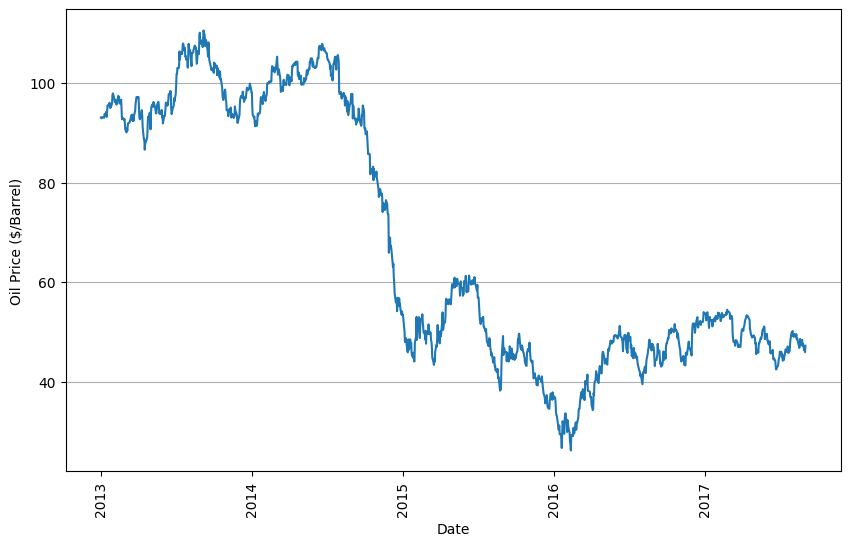

In [125]:
# Check the plot

plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(oil["date"]),oil["oil_price"])
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Oil Price ($/Barrel)")
plt.xticks(rotation=90)
plt.show()

### Oil merge

In [126]:
train_complete_merge = pd.merge(train_holidays_merged, oil, how='left')

In [127]:
train_complete_merge.tail()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,holiday_national_type,holiday_national,transferred_national,holiday_regional_type,holiday_regional,transferred_regional,holiday_local_type,holiday_local,transferred_local,oil_price
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.57
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,154.55300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.57
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,16.34952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.57
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,15.12500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.57
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,2017,8,15,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.57


In [128]:
len(train_rawdf) == len(train_complete_merge)

True

# Binarise Holiday Flags

Here we want to binarise the types of holidays/events.

In [129]:
# Binarise national, regional, local
train_complete_merge["holiday_national_binary"] = np.where(train_complete_merge.holiday_national.notnull(), 1, 0)
train_complete_merge["holiday_regional_binary"] = np.where(train_complete_merge.holiday_regional.notnull(), 1, 0)
train_complete_merge["holiday_local_binary"] = np.where(train_complete_merge.holiday_local.notnull(), 1, 0)

# Binarise earthequake and world cup
train_complete_merge["earthquake_binary"] = np.where(train_complete_merge.holiday_national == "Earthquake", 1, 0)
train_complete_merge["world_cup_binary"] = np.where(train_complete_merge.holiday_national == "2014 FIFA World Cup", 1, 0)

# Christmas flag
train_complete_merge["christmas_binary"] = np.where(train_complete_merge.holiday_national == "Christmas", 1, 0)
train_complete_merge.tail()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,holiday_local_type,holiday_local,transferred_local,oil_price,holiday_national_binary,holiday_regional_binary,holiday_local_binary,earthquake_binary,world_cup_binary,christmas_binary
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2017,8,15,inf,...,NaN,NaN,NaN,47.57,0,0,0,0,0,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2017,8,15,154.55300,...,NaN,NaN,NaN,47.57,0,0,0,0,0,0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2017,8,15,16.34952,...,NaN,NaN,NaN,47.57,0,0,0,0,0,0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2017,8,15,15.12500,...,NaN,NaN,NaN,47.57,0,0,0,0,0,0
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,2017,8,15,inf,...,NaN,NaN,NaN,47.57,0,0,0,0,0,0


In [130]:
# train_complete_merge.loc[train_complete_merge["holiday_national_binary"] == 1].sum()
print( "National: ", train_complete_merge["holiday_national_binary"].sum(), "Regional: ", train_complete_merge["holiday_regional_binary"].sum(), "Local: ", train_complete_merge["holiday_local_binary"].sum())
print( "Earthquake: ", train_complete_merge["earthquake_binary"].sum(),  "World cup: ", train_complete_merge["earthquake_binary"].sum(), )
print("Christmas: ", train_complete_merge["christmas_binary"].sum())


National:  254826 Regional:  1023 Local:  12243
Earthquake:  51678 World cup:  51678
Christmas:  39204


# Create New Variables

In [131]:
# Make date to date type
train_complete_merge['date'] = pd.to_datetime(train_complete_merge.date, format='%Y-%m-%d')

In [132]:
# DAY OF WEEK ----

# Create column for day of week
train_complete_merge['dayofwk'] = train_complete_merge['date'].dt.weekday

In [133]:
# FLAGS FOR 1ST, 15TH AND LAST DAY OF MONTH ----

# Flag for 1st of month
train_complete_merge['flag_1st'] = train_complete_merge['date'].dt.is_month_start.astype(int)

# Flag for last day of month
train_complete_merge['flag_lastday'] = train_complete_merge['date'].dt.is_month_end.astype(int)

# Flag for 15th of month
train_complete_merge.loc[train_complete_merge['day'] == 15, 'flag_15th'] = 1
train_complete_merge.loc[train_complete_merge['day'] != 15, 'flag_15th'] = 0
train_complete_merge['flag_15th'] = train_complete_merge['flag_15th'].astype(int)

In [134]:
train_complete_merge.head()

,id,date,store_nbr,family,sales,onpromotion,year,month,day,sales_to_promo_ratio,...,holiday_national_binary,holiday_regional_binary,holiday_local_binary,earthquake_binary,world_cup_binary,christmas_binary,dayofwk,flag_1st,flag_lastday,flag_15th
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,NaN,...,1,0,0,0,0,0,1,1,0,0
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,NaN,...,1,0,0,0,0,0,1,1,0,0
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,NaN,...,1,0,0,0,0,0,1,1,0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,NaN,...,1,0,0,0,0,0,1,1,0,0
4,4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,NaN,...,1,0,0,0,0,0,1,1,0,0


In [135]:
# Family - group Grocery I & II, and Home and Kitchen I & II

train_complete_merge.loc[(train_complete_merge['family'] == 'GROCERY I') | (train_complete_merge['family'] == 'GROCERY II'), 
                         'family_new'] = 'GROCERY'
train_complete_merge.loc[(train_complete_merge['family'] == 'HOME AND KITCHEN I') | (train_complete_merge['family'] == 'HOME AND KITCHEN II'), 
                         'family_new'] = 'HOME AND KITCHEN'